In [322]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [323]:
import os
import sys
import re
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from IPython.display import display, HTML, clear_output, Image
import pandas as pd
from itertools import product
import math
from deepdiff import DeepDiff

In [324]:
# Styling notebook
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML("<style>" + styles + "</style")

css_styling()

In [325]:
sys.path.insert(1, "/workspaces/ou-af/problem2/")

In [326]:
# import de code
import src.oopnclasses as oopnclasses
import src.oopnbuilder as oopnbuilder
import src.diagrambuilder as diagrambuilder
import src.testobservereplace as testchangeinput
import src.testchangeinput as testobservereplace
import specs.components as componentspecs
import specs.connections as connectionspecs
import specs.assemblies as assemblyspecs
import specs.tests as testspecs

In [327]:
def visualizeStructure(diagram):
#    display(HTML("<style>.container { width:100% !important; }</style>"))

    # print summary of nodes
    print(diagram)

    # view structure
    gnb.showInfluenceDiagram(diagram, size=60)
    
def createUtilityRow(nodelist):
    row_elements = [diagram.utility(node) for node in nodelist]
    gnb.flow.row(*row_elements)

def createCptRow(nodelist):
    row_elements = [diagram.cpt(node) for node in nodelist]
    gnb.flow.row(*row_elements)

def showCPTs(diagram):
    nodes = diagram.nodes()
    for n in nodes:
        if(diagram.isChanceNode(n)):
            gnb.flow.row(diagram.cpt(n))
            
def getDiagramChanceNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isChanceNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printCptTables(diagram, system):
    for component in system.getComponents():
        print("CPT tables for component: " + component.getName())
        createCptRow(getDiagramChanceNodeIdsForComponent(component.getName(), diagram))
        
def getDiagramUtilityNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isUtilityNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printUtilityTables(diagram, system):
    for component in system.getComponents():
        print("Utility tables for component: " + component.getName())
        createUtilityRow(getDiagramUtilityNodeIdsForComponent(component.getName(), diagram))

In [416]:
# gather specs for a system
# system = light + replacedecision + test
components = [componentspecs.light, componentspecs.switch]
connections = [connectionspecs.wire, connectionspecs.wire2]
tests = [testspecs.observeorreplacetest, testspecs.changeinputtest]
assembly = {
    "components"  : components,
    "connections" : connections,
    "structure"   : assemblyspecs.structure3,   #light, switch, wire
    "tests"       : tests,
    "testmapping" : testspecs.testmapping11
}

In [417]:
oopnbuilderinstance = oopnbuilder.OopnBuilder(assembly)
oopn = oopnbuilderinstance.getOopn()


star building system: structure3
createNodes0
False
kom hier niet
createNodes0
False
kom hier niet
createNodes0
False
kom hier niet
createNodes0
False
kom hier niet
createNodes0
False
kom hier niet
createNodes0
False
kom hier niet
number of components: 6
number of connections: 5
number of tests: 1


In [433]:
# create diagram object
diagram = gum.InfluenceDiagram()

In [434]:
diagram = diagrambuilder.diagramBuilder(diagram, oopn)

adding component: Light
adding component: Switch
adding component: Light1
adding component: Switch1
adding component: Light2
adding component: Switch2
adding component: switchcopy
duplicatehealthSwitch
adding connection between: PresentPowerOutputsSwitch and: PresentPowerInputsLight
adding connection between: PresentLightOutputsLight and: PresentPowerInputsSwitch1
adding connection between: PresentPowerOutputsSwitch1 and: PresentPowerInputsLight1
adding connection between: PresentLightOutputsLight1 and: PresentPowerInputsSwitch2
adding connection between: PresentPowerOutputsSwitch2 and: PresentPowerInputsLight2
adding cpt for component: Light
adding cpt for component: Switch
adding cpt for component: Light1
adding cpt for component: Switch1
adding cpt for component: Light2
adding cpt for component: Switch2
adding cpt for component: switchcopy
adding cpt for connection: Wire
adding cpt for connection: Wire2
adding cpt for connection: Wire3
adding cpt for connection: Wire4
adding cpt for

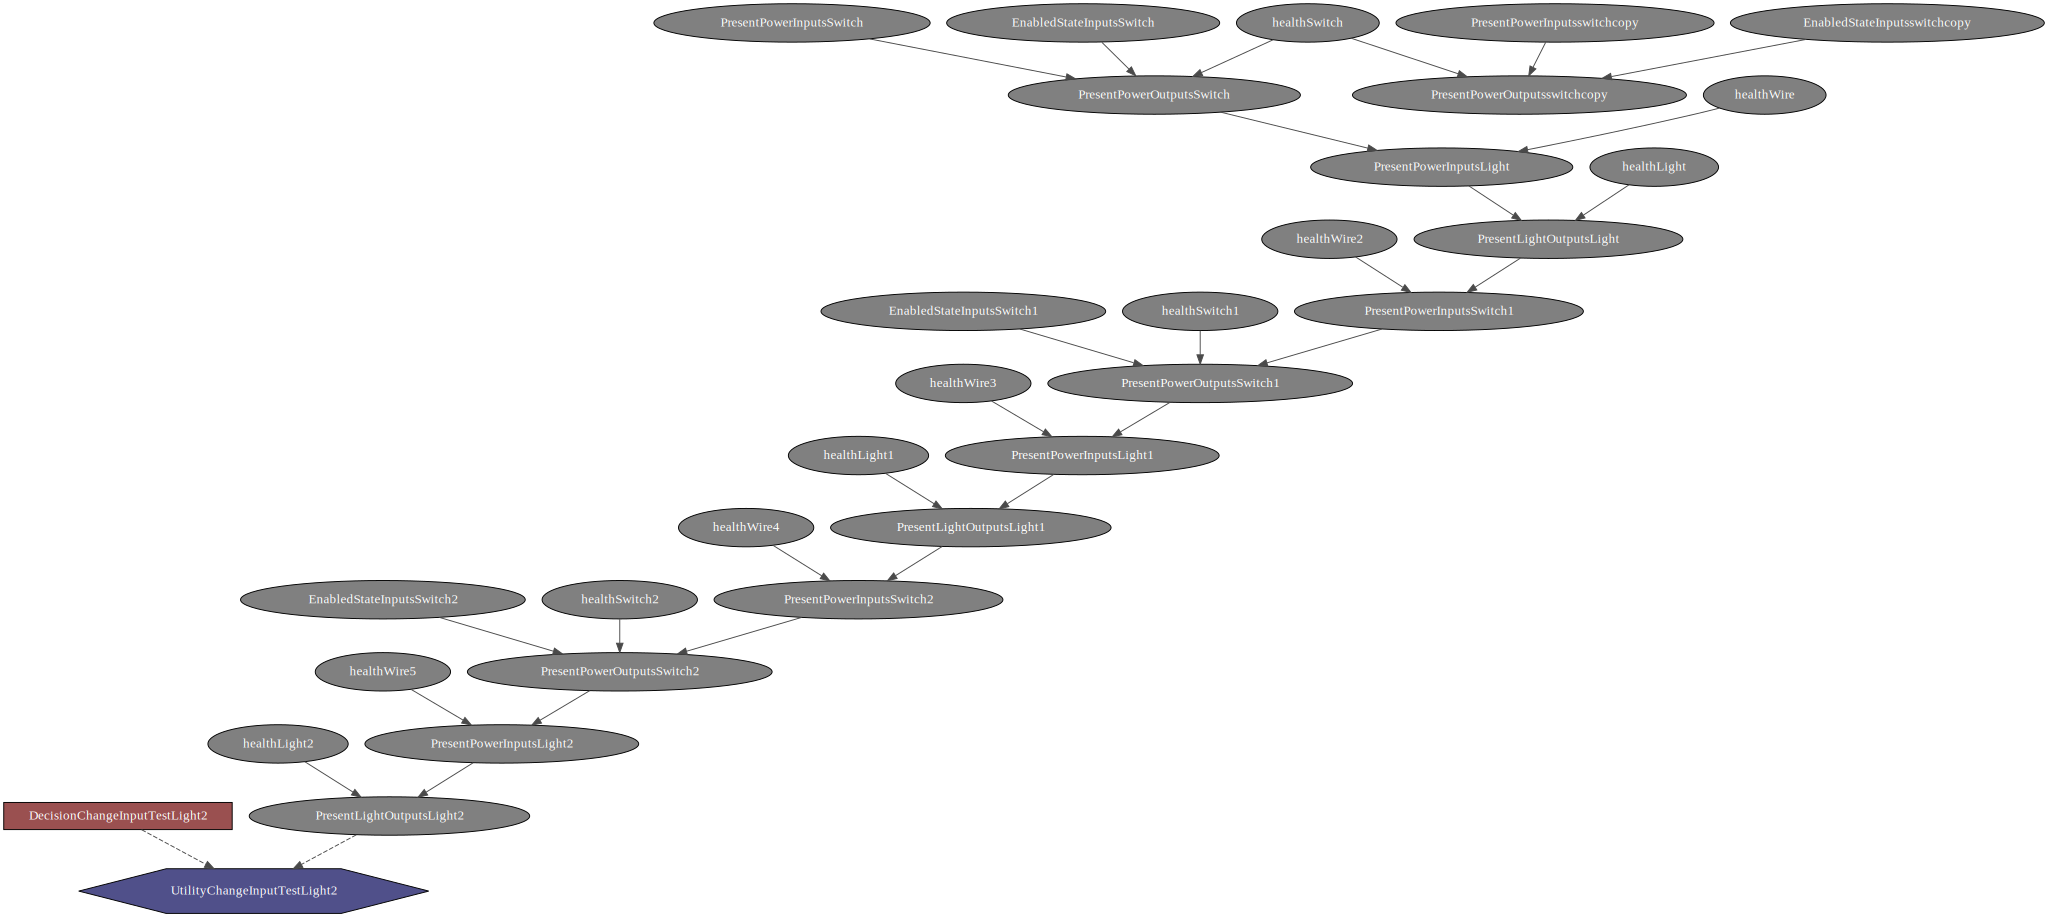

In [435]:
gnb.showInfluenceDiagram(diagram, size=60)

Type 2 test:
- voor een deel van de keten zijn er 2 sets aan evidence bijvoorbeeld EnabledStateInputsSwitch:0 / PresentLightOutputsLight2 en EnabledStateInputsSwitch:1 / PresentLightOutputsLight2
    - eis is dat startpunt van de keten een input is en eindpunt een outputnode
    - van een keten in het systeem zijn het beginpunt en het eindpunt bekend, niet de tussenliggende nodes
- indien 2 sets aan evidence worden geconstateerd dan gaan we terug naar informatiemodel
- met het informatiemodel berekenen we pad van begin tot einde van de keten via shortest pad methode 
  - wat als er meerdere paden zijn?
- een extra pad wordt aangebracht in het diagram
  - output van een component wordt vebonden met de health van die component
  - een connectienode wordt verbonden met de health van de connectie
- het extra pad wordt vastgehouden zodat bij inference de extra evidence aan dit pad kan worden verbonden

### mbv informatiemodel pad van de keten afleiden
- uit informatiemodel alle nodes en connecties halen
- opbouwen aparte networkx directed graph met nodes en connecties
- in de graph pad bepalen
- nodes van de keten bewaren

In [333]:
components = oopn.getComponents()
connections = oopn.getConnections()
conlist = []

for c in components:
    for n in c.getNodes():
        nodenames.append(n.getName())
    for ic in c.getInternalConnections():
        conlist.append(ic)
for con in connections:
#    print(type(con))
    conlist.append(con.getConnectionNodes())

#print(nodenames)
#print(conlist)

In [334]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(nodenames)
G.add_edges_from(conlist)

In [335]:
if (nx.has_path(G, 'EnabledStateInputsSwitch', 'PresentLightOutputsLight2')):
    systempath = nx.shortest_path(G, 'EnabledStateInputsSwitch', 'PresentLightOutputsLight2')
else: print('Error no path available')

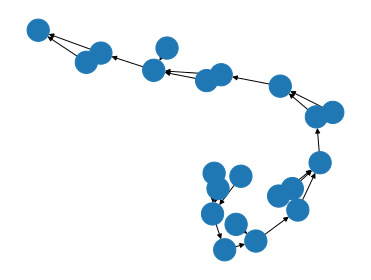

In [336]:
import matplotlib.pyplot as plt
subax1 = plt.subplot()
#nx.draw(G, with_labels=True, font_color='white', node_size=2000)
nx.draw(G, font_color='white', node_size=500)

In [337]:
systempath

['EnabledStateInputsSwitch',
 'PresentPowerOutputsSwitch',
 'PresentPowerInputsLight',
 'PresentLightOutputsLight',
 'PresentPowerInputsSwitch1',
 'PresentPowerOutputsSwitch1',
 'PresentPowerInputsLight1',
 'PresentLightOutputsLight1',
 'PresentPowerInputsSwitch2',
 'PresentPowerOutputsSwitch2',
 'PresentPowerInputsLight2',
 'PresentLightOutputsLight2']

- verwerklijst(component, lijst)
  - zoek component
  - bepaal welke nodes moeten worden hergebruikt
  - maak nieuwe component met naam_copy en plus her te gebruiken nodes
  

- per item in systempath
    - bepaal component, 
    - indien zelfde component, 
      - zet op lijst te verwerken
    - indien nieuwe component, 
      - verwerk lijst tot nu toe opgebouwd voor 1 component
      - check de te verwerken lijst connectie en leg die aan
      - bepaal connectie nieuwe en oude component
        - zet connectie op te verwerken lijst

In [372]:
# derive components belonging to given path
def determineComponents(path):
    componentlist = []
    for nodename in path:
        component = oopn.findComponentFromNodeName(nodename)
        componentnodes = component.getNodes()
        for cn in componentnodes:
            if (nodename == cn.getName()):
                componentlist.append(component)
    return componentlist

In [373]:
print(determineComponents(systempath))


[<src.oopnclasses.Component object at 0xffff23d5fc50>, <src.oopnclasses.Component object at 0xffff23d5fc50>, <src.oopnclasses.Component object at 0xffff286e9610>, <src.oopnclasses.Component object at 0xffff286e9610>, <src.oopnclasses.Component object at 0xffff2cfa9590>, <src.oopnclasses.Component object at 0xffff2cfa9590>, <src.oopnclasses.Component object at 0xffff2cfaa8d0>, <src.oopnclasses.Component object at 0xffff2cfaa8d0>, <src.oopnclasses.Component object at 0xffff2cf18290>, <src.oopnclasses.Component object at 0xffff2cf18290>, <src.oopnclasses.Component object at 0xffff2cb3e550>, <src.oopnclasses.Component object at 0xffff2cb3e550>]


In [374]:
for l in assembly["components"]:
    if (l["type"] == "Switch"):
        specs = l

In [423]:

nodestoreuse = []
for c in oopn.getComponents():
    print(c.getName())
    for n in c.getNodes():
        if (n.getName() == "healthSwitch"):
            print(n.getName())
            nodestoreuse.append(n)
                

# create new Component object + append to list
newc = oopnclasses.Component('switchcopy', specs, nodestoreuse)
oopn.addComponent(newc)

Light
Switch
healthSwitch
Light1
Switch1
Light2
Switch2
createNodes1
True


In [424]:
for n in newc.getNodes():
    print(n.getName())

healthSwitch
PresentPowerOutputsswitchcopy
PresentPowerInputsswitchcopy
EnabledStateInputsswitchcopy


In [390]:
newc.getName()

'switchcopy'

In [20]:
# outputtest
testutility = diagram.addUtilityNode(gum.LabelizedVariable("outputTest", "outputTest", 1))
testdecision = diagram.addDecisionNode(gum.LabelizedVariable("testdecision", "testdecisionl", ["yes", "no"]))
testoutcome = diagram.addChanceNode(gum.LabelizedVariable("testoutcome", "testoutcome", ["ok", "problem", "notdone"]))
diagram.addArc(diagram.idFromName("PresentLightOutputsLight"), testutility)
diagram.addArc(testdecision, testutility)
diagram.addArc(testdecision, testoutcome)
diagram.addArc(diagram.idFromName("healthWire"), testoutcome)
diagram.addArc(diagram.idFromName("healthSwitch"), testoutcome)
diagram.addArc(diagram.idFromName("healthLight"), testoutcome)

In [22]:
printCptTables(diagram, oopn)

CPT tables for component: Light


CPT tables for component: Switch


In [23]:
printUtilityTables(diagram, oopn)

Utility tables for component: Light


Utility tables for component: Switch


In [143]:
evs = {
'PresentLightOutputsLight':1,
#'testoutcome':0

#'PresentPowerInputsLight':1,

#'PresentPowerOutputsSwitch':0,
#'PresentPowerInputsSwitch':1,
#'EnabledStateInputsSwitch':0,

# 'DecisionReplaceLight':,
# 'DecisionReplaceSwitch':,
# 'DecisionTestObserveHealthLight':,
# 'DecisionTestObserveHealthSwitch':,

# 'TestOutcomeTestObserveHealthLight':,
# 'TestOutcomeTestObserveHealthSwitch':,
# 'UtilityReplaceLight':,
# 'UtilityReplaceSwitch':,
# 'UtilityTestObserveHealthLight':,
# 'UtilityTestObserveHealthSwitch':,
# 'healthLight':,
# 'healthSwitch':,
# 'healthWire':
}


In [144]:
ie = gum.ShaferShenoyLIMIDInference(diagram) 
ie.setEvidence(evs)
#ie.addNoForgettingAssumption(["DecisionTestObserveHealthSwitch","DecisionReplaceSwitch", "DecisionTestObserveHealthLight", "DecisionReplaceLight"])
gnb.sideBySide(gnb.getInference(diagram,engine=ie, evs=evs, size=200))

In [26]:
diagram.utility("outputTest")[{"testdecision":"yes", "PresentLightOutputsLight":"no"}] = 4
diagram.utility("outputTest")[{"testdecision":"no", "PresentLightOutputsLight":"no"}] = 3
diagram.utility("outputTest")[{"testdecision":"yes", "PresentLightOutputsLight":"yes"}] = 2
diagram.utility("outputTest")[{"testdecision":"no", "PresentLightOutputsLight":"yes"}] = 1
diagram.utility("outputTest")

(pyAgrum.Potential<double>@0x22503660) 
             ||  outputT|
Presen|testde||0        |
------|------||---------|
yes   |yes   || 2.0000  |
no    |yes   || 4.0000  |
yes   |no    || 1.0000  |
no    |no    || 3.0000  |

In [27]:
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"ok","testdecision":"yes" }] = [0.98, 0.01, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]

diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"ok","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]

diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"ok","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]

diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"ok","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]


In [28]:
diagram.cpt(diagram.idFromName("testoutcome"))

(pyAgrum.Potential<double>@0x2266aed0) 
                           ||  testoutcome                |
testde|health|health|health||ok       |problem  |notdone  |
------|------|------|------||---------|---------|---------|
yes   |ok    |ok    |ok    || 0.9800  | 0.0100  | 0.0100  |
no    |ok    |ok    |ok    || 0.0100  | 0.0100  | 0.9800  |
yes   |broken|ok    |ok    || 0.0100  | 0.9800  | 0.0100  |
no    |broken|ok    |ok    || 0.0100  | 0.0100  | 0.9800  |
yes   |ok    |broken|ok    || 0.0100  | 0.9800  | 0.0100  |
no    |ok    |broken|ok    || 0.0100  | 0.0100  | 0.9800  |
[...4 more line(s) ...]
yes   |broken|ok    |broken|| 0.0100  | 0.9800  | 0.0100  |
no    |broken|ok    |broken|| 0.0100  | 0.0100  | 0.9800  |
yes   |ok    |broken|broken|| 0.0100  | 0.9800  | 0.0100  |
no    |ok    |broken|broken|| 0.0100  | 0.0100  | 0.9800  |
yes   |broken|broken|broken|| 0.0100  | 0.9800  | 0.0100  |
no    |broken|broken|broken|| 0.0100  | 0.0100  | 0.9800  |

In [29]:
diagram.cpt.posterior("outputTest")

AttributeError: 'function' object has no attribute 'posterior'

In [30]:
ie.posteriorUtility("UtilityReplaceWire")

NotFound: [pyAgrum] Object not found: No element with the key <UtilityReplaceWire>

In [31]:
a = -5*.0087 + -2*.0013
b = 0 + -4* .1238
print(a+b)

-0.5413


In [ ]:
gnb.showInfluenceDiagram(diagram, size=60)

In [177]:
from collections import defaultdict, deque

# Class to represent a graph using adjacency list


class Graph:
    def __init__(self):
        self.adjList = defaultdict(list)

    # Function to add an edge to the graph
    def addEdge(self, u, v):
        self.adjList[u].append(v)

    # Function to perform Breadth First Search on a graph represented using adjacency list
    def bfs(self, startNode):
        # Create a queue for BFS
        queue = deque()
        visited = [False] * (max(self.adjList.keys()) + 1)

        # Mark the current node as visited and enqueue it
        visited[startNode] = True
        queue.append(startNode)

        # Iterate over the queue
        while queue:
            # Dequeue a vertex from queue and print it
            currentNode = queue.popleft()
            print(currentNode, end=" ")

            # Get all adjacent vertices of the dequeued vertex currentNode
            # If an adjacent has not been visited, then mark it visited and enqueue it
            for neighbor in self.adjList[currentNode]:
                if not visited[neighbor]:
                    visited[neighbor] = True
                    queue.append(neighbor)


# Create a graph
graph = Graph()

# Add edges to the graph
graph.addEdge(0, 1)
graph.addEdge(0, 2)
graph.addEdge(1, 3)
graph.addEdge(1, 4)
graph.addEdge(2, 4)

# Perform BFS traversal starting from vertex 0
print("Breadth First Traversal starting from vertex 0:", end=" ")
graph.bfs(0)


Breadth First Traversal starting from vertex 0: 0 1 

IndexError: list index out of range

In [193]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(range(100, 105))
G.add_edges_from([(100, 101), (100, 103), (101,104), (103,102)])


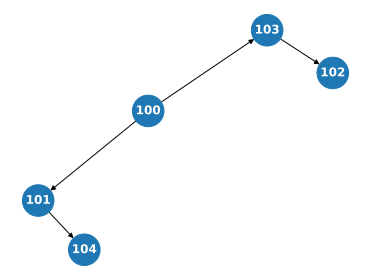

In [194]:
import matplotlib.pyplot as plt
subax1 = plt.subplot()
nx.draw(G, with_labels=True, font_weight='bold', font_color='white', node_size=1000)


In [196]:
nx.has_path(G, 100, 104)

True

In [197]:
nx.shortest_path(G, 100, 104)

[100, 101, 104]

In [ ]:
nx.has_path(G, 100, 104)
nx.shortest_path(G, 100, 104)